## Blasting known HCN genes against the white clover reference genome

So far, we have not been able to differentiate homzygous dominant (e.g., AcAc) white clover individuals from heterozygous (e.g., Acac) individuals using PCR since the dominance of the markers and the multiple deletions at both loci result in preferential amplification of the smaller deletion, masking the genotype on the other homologous chromosome. We therefore need to design a PCR primer that spans the entire deletion boundary, which would allow us to resolve homozygous and heterozygous individuals on a gel based on the number and size of bands.

Alternatively, we may be able to differentiate the genotypes based on sequence coverage around the deletion: Homozygous dominant individuals should have twice the coverage of heterozygotes, and individuals homozygous for the deletions should have no coverage.

In either case, we need to know where in the genome the HCN loci are located. To find them, we can blast the sequences of all known HCN genes against the recently published white clover genome (Griffiths _et al._ 2019, Plant Cell).

## Creating BED file with HCN gene regions

I BLASTed the HCN genes against the reference genome and examined the top hits. I also greped the GTF file for the HCN loci annotations; the top BLAST hits matched the locations of the genes in the reference genome's annotation file. 

However, the start and end coordinates for the BLAST hist are within the bounds of those reported in the annotation file. I therefore used the annotation file coordinated to create a BED file and passed this to `samtools depth` to get per base-pair coverage in the regions around these loci for each of the 120 sampled sequenced in Toronto.

In [78]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [17]:
blast_results = pd.read_table('../resources/HCN_griffithsGenome_Blast.txt')
accessions = pd.read_table('../resources/T-repens_HCN_AccessionNumbers.txt',
                          sep = '\t', names=['Accession', 'Description'])

In [32]:
blast_results['qseqid'].drop_duplicates()

0      KJ467261.1
13     KJ467326.1
19     JQ920491.1
31     JQ920574.1
56     JQ920575.1
81     EF990447.1
98     JQ920572.1
123    JQ920573.1
144    JQ920570.1
156    MH059954.1
Name: qseqid, dtype: object

In [37]:
blast_results[blast_results['qseqid'] == 'KJ467326.1']

,qseqid,sseqid,pident,length,mismatch,gapopen,qstart,qend,qlen,sstart,send,slen,evalue,bitscore,qcovs,qcovhsp
13,KJ467326.1,CM019103.1,97.737,1679,3,3,1,1679,1679,19570565,19572208,54415314,0.000000e+00,2857.0,100,100
14,KJ467326.1,CM019102.1,98.643,958,1,1,1,958,1679,15999404,16000349,62546397,0.000000e+00,1687.0,100,57
15,KJ467326.1,CM019102.1,97.140,874,2,2,806,1679,1679,16000351,16001201,62546397,0.000000e+00,1454.0,100,52
16,KJ467326.1,CM019104.1,97.362,872,4,1,808,1679,1679,14276446,14277298,40013283,0.000000e+00,1465.0,52,52
17,KJ467326.1,CM019101.1,74.476,525,114,17,1101,1617,1679,47897944,47897432,95903191,1.070000e-51,209.0,31,31
18,KJ467326.1,CM019101.1,80.808,99,18,1,1098,1196,1679,47883021,47882924,95903191,1.130000e-11,76.8,31,6


In [47]:
# The following positions are from the white clover reference annotation file
# The coordinates from the BLAST search are within these bounds
genes_dict = {'CYP': ['CM019103.1', 19570532, 19572232],
             'Li': ['CM019108.1', 30227327, 30233709]}

In [48]:
with open('../resources/hcn_coding_sequences_withFlanks.bed', 'w') as f:
    buffer = 5000
    for gene, coords in genes_dict.items():
        chrom = coords[0]
        start = coords[1] - buffer
        end = coords[2] + buffer
        f.write('{0}\t{1}\t{2}\t{3}\n'.format(chrom, start, end, gene))

## Plotting coverage along the HCN loci

In [91]:
Li_start = 30227327
Li_end = 30233709
Ac_start = 19570521
Ac_end = 19572232

### Two high-coverage genomes

In [102]:
def import_samtools_depth(path, locus, buffer=3500):
    
    names = ['CHROM', 'POS', 'DP']
    df_out = pd.read_table(path, names = names)
    
    if locus == 'Li':
        df_out = df_out[df_out['CHROM'] == 'CM019108.1']
        start = Li_start - buffer
        end = Li_end + buffer
        df_out = df_out[(df_out['POS'] > start) & (df_out['POS'] < end)]
    elif locus == 'Ac':
        df_out = df_out[df_out['CHROM'] == 'CM019103.1']
        start = Ac_start - buffer
        end = Ac_end + buffer
        df_out = df_out[(df_out['POS'] > start) & (df_out['POS'] < end)]
    else:
        df_out = df_out
    
    return df_out

In [103]:
def plot_coverage_along_chrom(df, locus):
    
    plt.figure(figsize=(20, 5)) 

    ax = plt.subplot()    
    ax.spines["top"].set_visible(False)    
    ax.spines["right"].set_visible(False)    
    ax.get_xaxis().tick_bottom()    
    ax.get_yaxis().tick_left() 
    
    plt.plot(df['POS'], df['DP'])
    
    if locus == 'Li':    
        plt.axvline(x=Li_start, color = 'r')
        plt.axvline(x=Li_end, color = 'r')
    elif locus == 'Ac':
        plt.axvline(x=Ac_start, color = 'r')
        plt.axvline(x=Ac_end, color = 'r')

    ax.set_xlabel('Chromosomal position')
    ax.set_ylabel('Depth')
    
    plt.show()

In [104]:
# Negative at Li
jack = '../../sequencingTwoGenomes_Cyan-Acyan/analysis/samptools_depth/jacksonville_hcnLoci.depth'
jack_li = import_samtools_depth(jack, 'Li')

# Positive at Li
tamp = '../../sequencingTwoGenomes_Cyan-Acyan/analysis/samptools_depth/tampa_hcnLoci.depth'
tamp_li = import_samtools_depth(tamp, 'Li')

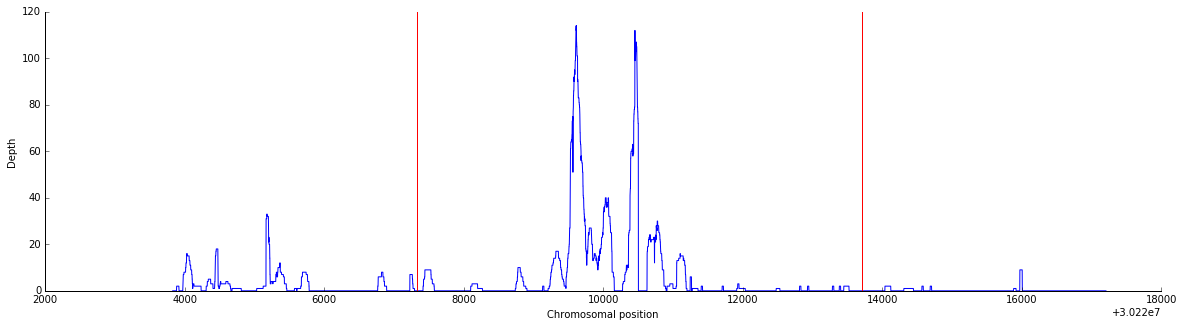

In [105]:
plot_coverage_along_chrom(jack_li, locus = 'Li')

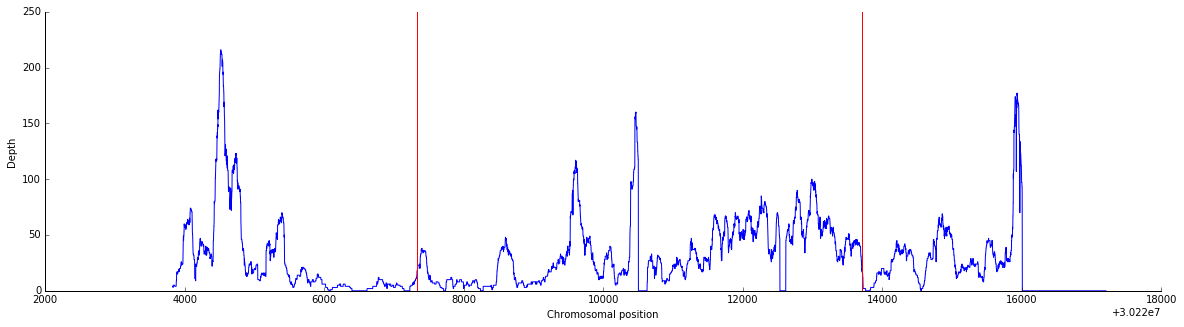

In [106]:
plot_coverage_along_chrom(tamp_li, locus = 'Li')

In [107]:
jack_ac = import_samtools_depth(jack, 'Ac')
tamp_ac = import_samtools_depth(tamp, 'Ac')

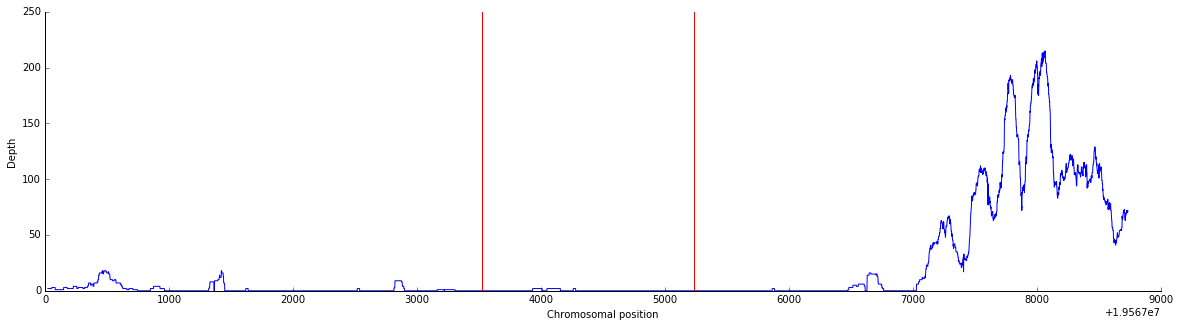

In [108]:
plot_coverage_along_chrom(jack_ac, locus = 'Ac')

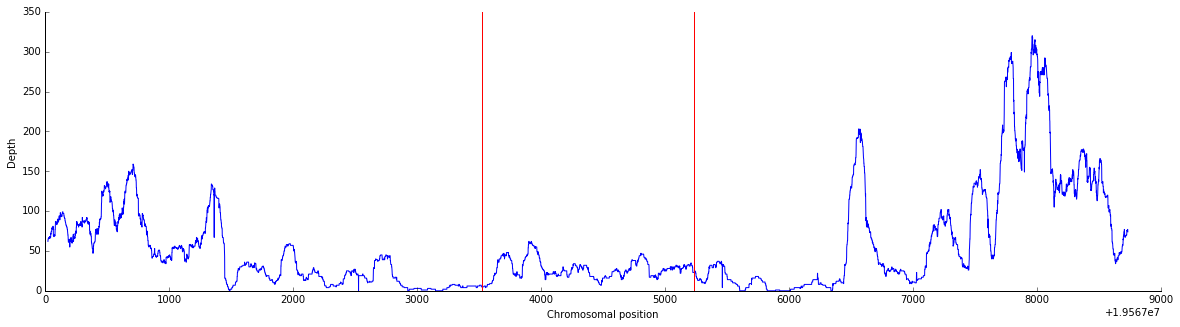

In [109]:
plot_coverage_along_chrom(tamp_ac, locus = 'Ac')

In [5]:
phenotype_data = '../resources/sequencedPlants_phenotypesHabitat.txt'
phenotype_data = pd.read_table(phenotype_data, sep = '\t')

In [32]:
phenotype_data

,Sample,Habitat,Population,Plant,HCN_Result,Locus.Li,Locus.Ac
0,s_40_1,Urban,40,1,0.0,NaN,0.0
1,s_40_3,Urban,40,3,0.0,NaN,0.0
2,s_40_6,Urban,40,6,0.0,NaN,0.0
3,s_40_7,Urban,40,7,0.0,NaN,0.0
4,s_40_8,Urban,40,8,0.0,NaN,1.0
5,s_40_10,Urban,40,10,0.0,NaN,0.0
6,s_40_12,Urban,40,12,1.0,NaN,1.0
7,s_40_17,Urban,40,17,0.0,NaN,1.0
8,s_40_19,Urban,40,19,0.0,NaN,0.0
9,s_41_1,Urban,41,1,0.0,0.0,NaN


### Li

In [110]:
# Negative at Li
s_41_1 = '../analysis/samptools_depth/s_41_1_hcnLoci.depth'
s_41_1 = import_samtools_depth(s_41_1, locus = 'Li')

# Positive at Li
s_41_2 = '../analysis/samptools_depth/s_41_2_hcnLoci.depth'
s_41_2 = import_samtools_depth(s_41_2, locus = 'Li')

### Ac

In [111]:
# Positive at Ac
s_42_10 = '../analysis/samptools_depth/s_42_10_hcnLoci.depth'
s_42_10 = import_samtools_depth(s_42_10, locus = 'Ac')

# Negative at Ac
s_42_11 = '../analysis/samptools_depth/s_42_11_hcnLoci.depth'
s_42_11 = import_samtools_depth(s_42_11, locus = 'Ac')

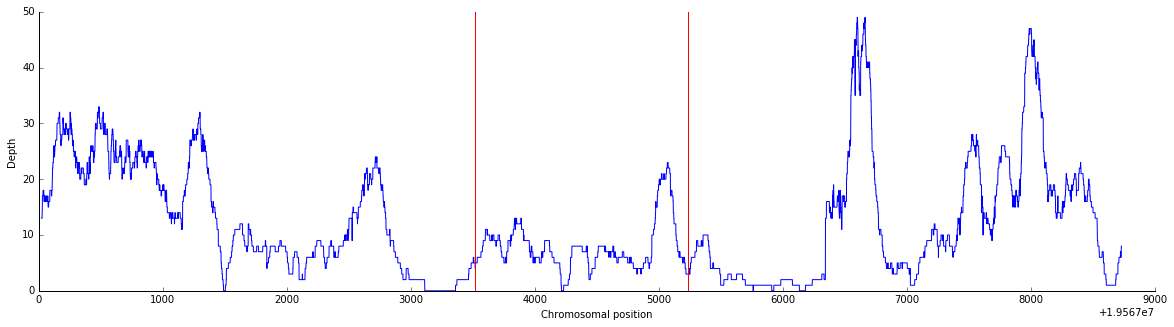

In [112]:
plot_coverage_along_chrom(s_42_10, locus = 'Ac')

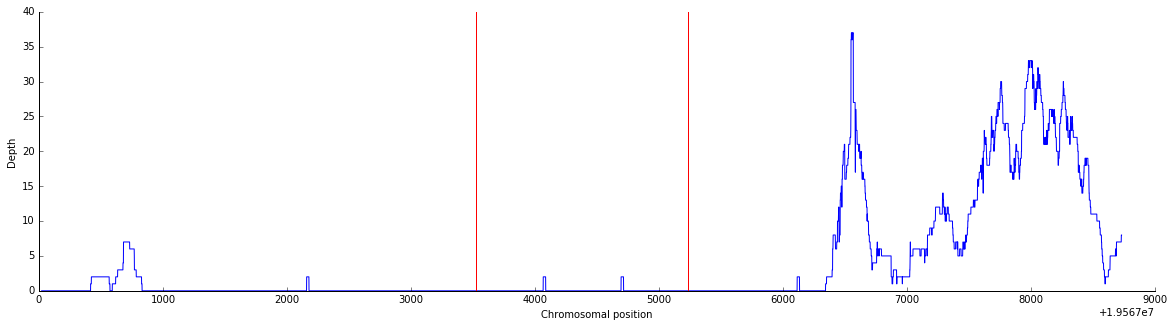

In [113]:
plot_coverage_along_chrom(s_42_11, locus = 'Ac')